--------------------------------------------------------------------------------
Running experiment for S. cerevisiae
Classifiers:  ['SC_ALL', 'SC_GENPROT', 'SC_NO_GENPROT']
--------------------------------------------------------------------------------
--------------------------------------------------
Running classifier SC_ALL
--------------------------------------------------
Features: 42, Mean PPV (1%): 0.5686956521739132
Features: 41, Mean PPV (1%): 0.5573913043478261
Features: 40, Mean PPV (1%): 0.553913043478261
Features: 39, Mean PPV (1%): 0.5656521739130433
Features: 38, Mean PPV (1%): 0.57
Features: 37, Mean PPV (1%): 0.5865217391304349
Features: 36, Mean PPV (1%): 0.5982608695652175
Features: 35, Mean PPV (1%): 0.6234782608695653
Features: 34, Mean PPV (1%): 0.6082608695652174
Features: 33, Mean PPV (1%): 0.5973913043478262
Features: 32, Mean PPV (1%): 0.6386956521739131
Features: 31, Mean PPV (1%): 0.5921739130434783
Features: 30, Mean PPV (1%): 0.6465217391304349
Features

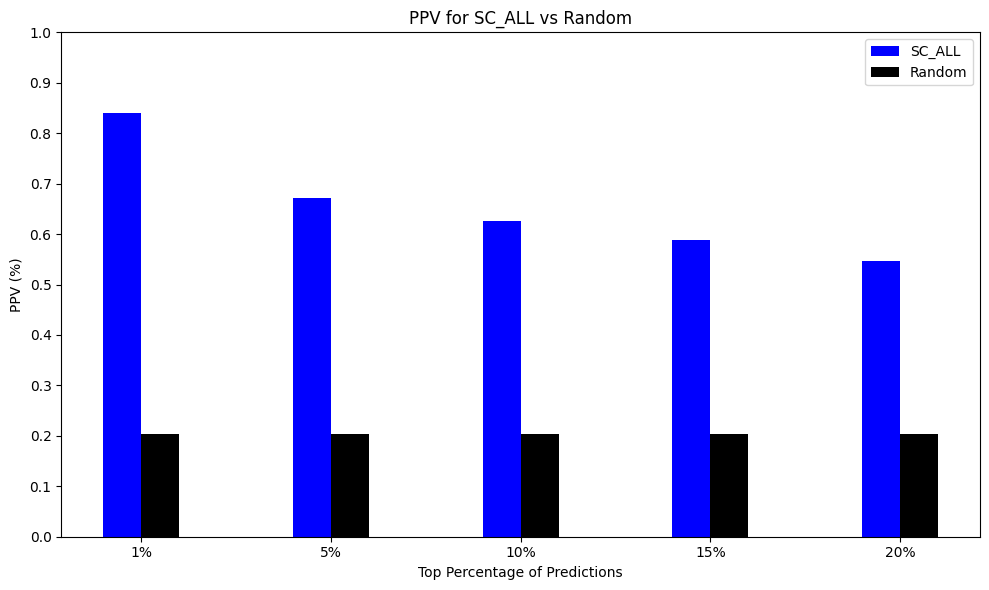

--------------------------------------------------
Running classifier SC_GENPROT
--------------------------------------------------
Features: 16, Mean PPV (1%): 0.7943478260869565
Features: 15, Mean PPV (1%): 0.7882608695652172
Features: 14, Mean PPV (1%): 0.778695652173913
Features: 13, Mean PPV (1%): 0.7826086956521741
Features: 12, Mean PPV (1%): 0.7843478260869565
Features: 11, Mean PPV (1%): 0.8526086956521739
Features: 10, Mean PPV (1%): 0.8482608695652175
Features: 9, Mean PPV (1%): 0.8578260869565216
Features: 8, Mean PPV (1%): 0.8508695652173911
Features: 7, Mean PPV (1%): 0.7813043478260869
Features: 6, Mean PPV (1%): 0.7960869565217391
Features: 5, Mean PPV (1%): 0.7878260869565216
Features: 4, Mean PPV (1%): 0.7260869565217392
Features: 3, Mean PPV (1%): 0.6982608695652172
Features: 2, Mean PPV (1%): 0.6360869565217392
Features: 1, Mean PPV (1%): 0.5843478260869566
Highest PPV (1%): 0.8578260869565216
Optimal number of features: 9
Final PPV Percentiles: [0.85173913 0.709237

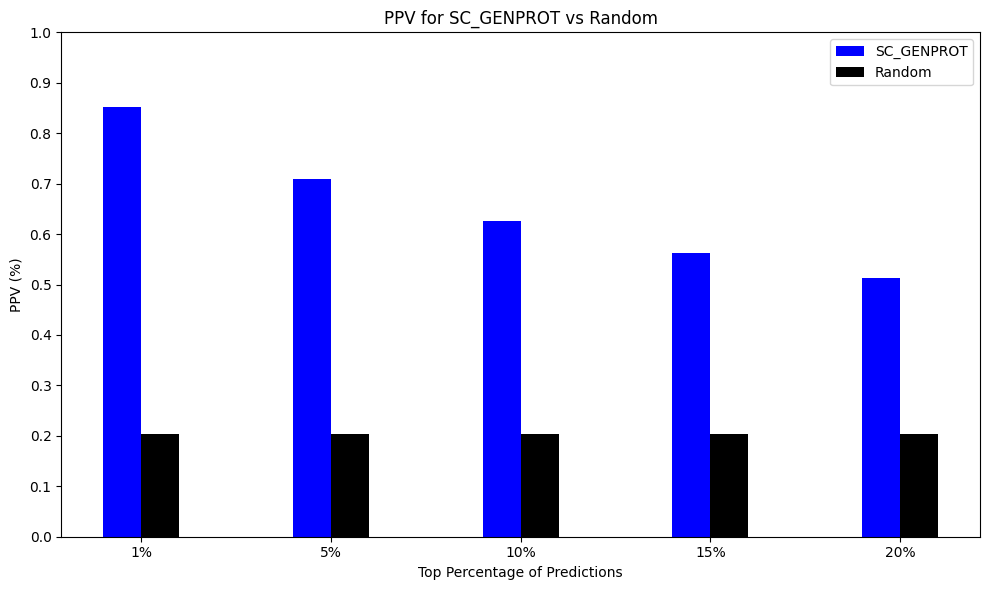

--------------------------------------------------
Running classifier SC_NO_GENPROT
--------------------------------------------------
Features: 15, Mean PPV (1%): 0.6373913043478261
Features: 14, Mean PPV (1%): 0.5626086956521739
Features: 13, Mean PPV (1%): 0.5734782608695652
Features: 12, Mean PPV (1%): 0.5313043478260869
Features: 11, Mean PPV (1%): 0.5252173913043479
Features: 10, Mean PPV (1%): 0.5234782608695652
Features: 9, Mean PPV (1%): 0.45826086956521744
Features: 8, Mean PPV (1%): 0.47260869565217384
Features: 7, Mean PPV (1%): 0.5208695652173914
Features: 6, Mean PPV (1%): 0.5065217391304347
Features: 5, Mean PPV (1%): 0.5313043478260869
Features: 4, Mean PPV (1%): 0.5134782608695653
Features: 3, Mean PPV (1%): 0.37652173913043474
Features: 2, Mean PPV (1%): 0.3043478260869565
Features: 1, Mean PPV (1%): 0.258695652173913
Highest PPV (1%): 0.6373913043478261
Optimal number of features: 15
Final PPV Percentiles: [0.62478261 0.47762712 0.40966102 0.39929379 0.37811441]


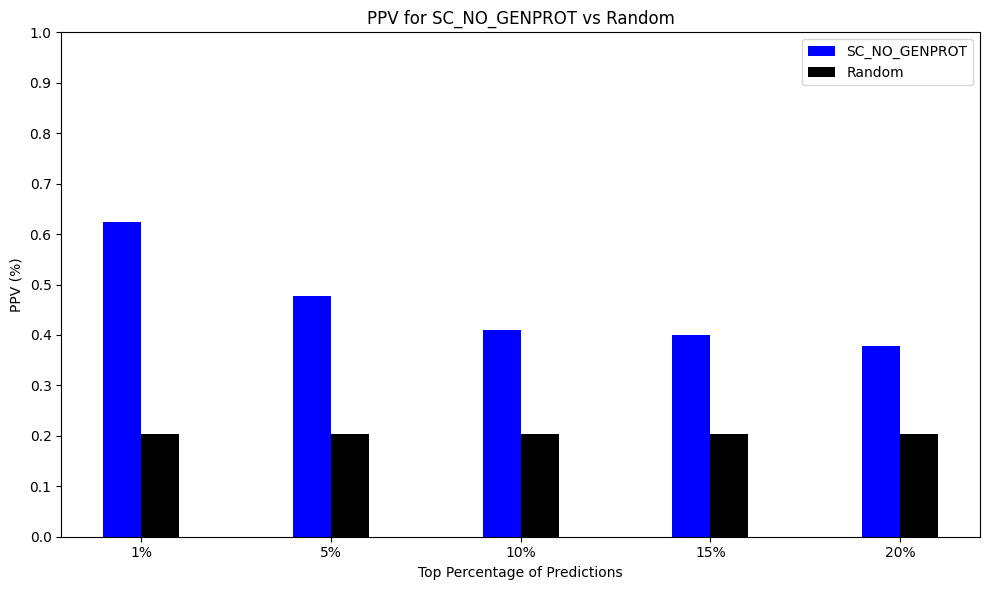

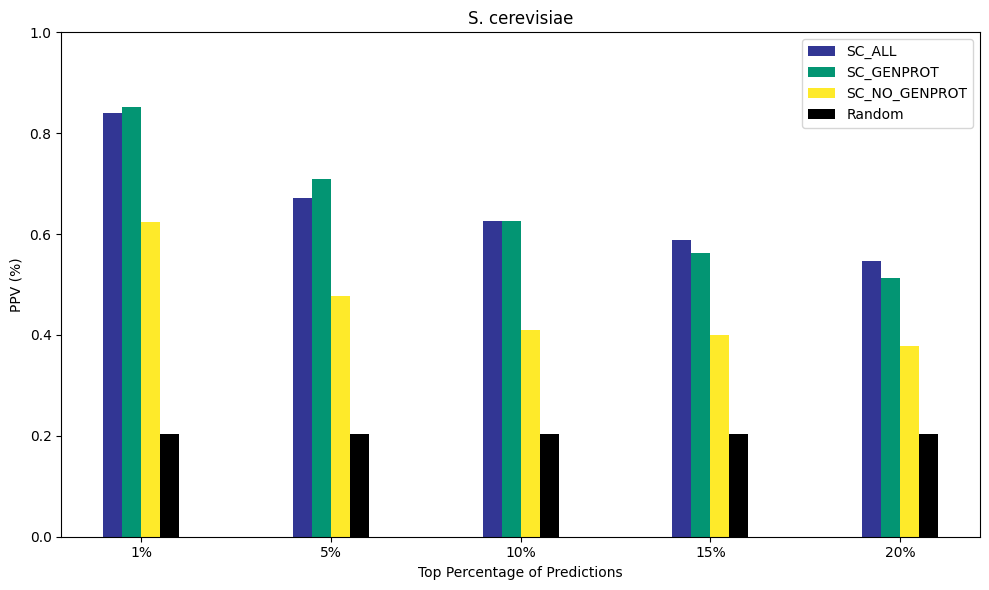

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt



PERCENTILES = [1, 5, 10, 15, 20] # Top 1%, 5%, 10%, 15%, 20%
ITERATIONS = 100  # Use 100 iterations as per the article


# CMIM ranking of features pre-calculated
CMIM_SC_NO_GENPROT = ['paralagous_count', 'upstream_size',  'CAI', 'GLU',
                'aromaticity_score', 'Gravy_score', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG',  'Codon_bias']

CMIM_SC_GENPROT = ['phyletic_retention', 'paralagous_count', 'upstream_size',  'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
               'PI', 'MET', 'ASP', 'GLN',  'LYS', 'FOP_score', 'ARG']

CMIM_SC_ALL = ['phyletic_retention', 'paralagous_count', 'DIP_degree', 'nucleolus',
                'nucleus', 'upstream_size', 'spindle pole', 'GLU', 'Codon_bias',
                'aromaticity_score', 'Gravy_score', 'CAI', 'downstream_size',
                'vacuole', 'endosome', 'mitochondrion', 'PI', 'cytoplasm',
                'promoter_count(Harbison_et_al)', 'vacuolar membrane', 'MET', 'ASP',
                'ER to Golgi', 'GLN', 'peroxisome', 'num places loc', 'LYS',
                'ambiguous', 'cell periphery', 'FOP_score', 'nuclear periphery', 'ARG',
                'Golgi to ER', 'punctate composite', 'ER', 'lipid particle', 'microtubule',
                'Golgi', 'bud neck', 'actin', 'bud', 'Golgi to Vacuole']





class EssentiallyClassifier:
    def __init__(self, file_path, cmim_ranking, percentiles, iterations,name):
        self.name = name
        self.file_path = file_path
        self.cmim_ranking = cmim_ranking
        self.percentiles = percentiles
        self.iterations = iterations
        self.X = None
        self.y = None
        self.optimal_features = None
        self.highest_ppv_1 = 0
        self.final_ppv_scores = []

    def load_discretized_data(self):
        discretized_data = pd.read_excel(self.file_path, sheet_name='entropy discretized')
        columns_with_symbols = discretized_data.columns[2:]
        label_encoders = {}

        for column in columns_with_symbols:
            le = LabelEncoder()
            discretized_data[column] = le.fit_transform(discretized_data[column].astype(str))
            label_encoders[column] = le

        self.X = discretized_data.drop(columns=['Essential', 'orf_id'])
        self.y = discretized_data['Essential']

    def calculate_top_percentile_ppv(self, probabilities, true_labels):
        sorted_indices = np.argsort(probabilities)[::-1]
        sorted_labels = true_labels[sorted_indices]
        ppv_percentiles = []

        for p in self.percentiles:
            n_top = int(len(sorted_labels) * (p / 100))
            if n_top == 0:
                ppv_percentiles.append(0)
            else:
                top_labels = sorted_labels[:n_top]
                ppv = np.sum(top_labels) / len(top_labels)
                ppv_percentiles.append(ppv)

        return ppv_percentiles

    def calcolate_boostrap_iteration(self, X_selected):
        X_train, X_test, y_train, y_test = train_test_split(X_selected, self.y, test_size=0.5, stratify=self.y)

        X_train_minority = X_train[y_train == 1]
        y_train_minority = y_train[y_train == 1]

        # X_train_oversampled, y_train_oversampled = resample(
        #     X_train_minority, y_train_minority,
        #     replace=True,
        #     n_samples=np.sum(y_train == 0),
        #     random_state=42
        # )

        X_train_oversampled = X_train_minority
        y_train_oversampled = y_train_minority

        X_train_balanced = pd.concat([X_train[y_train == 0], X_train_oversampled])
        y_train_balanced = pd.concat([y_train[y_train == 0], y_train_oversampled])

        nb_classifier = GaussianNB()
        nb_classifier.fit(X_train_balanced, y_train_balanced)
        y_prob = nb_classifier.predict_proba(X_test)[:, 1]

        return self.calculate_top_percentile_ppv(y_prob, y_test.to_numpy())

    def find_optimal_features(self):
        X_ranked = self.X[self.cmim_ranking]

        for i in range(len(self.cmim_ranking), 0, -1):
            X_selected = X_ranked.iloc[:, :i]
            ppv_1_scores = []

            for _ in range(self.iterations):
                ppv_iteration = self.calcolate_boostrap_iteration(X_selected)
                ppv_1_scores.append(ppv_iteration[0])

            mean_ppv_1 = np.mean(ppv_1_scores)
            print(f"Features: {i}, Mean PPV (1%): {mean_ppv_1}")

            if mean_ppv_1 > self.highest_ppv_1:
                self.highest_ppv_1 = mean_ppv_1
                self.optimal_features = i

        print("Highest PPV (1%):", self.highest_ppv_1)
        print("Optimal number of features:", self.optimal_features)

    def evaluate_final_model(self):
        X_optimal = self.X[self.cmim_ranking].iloc[:, :self.optimal_features]

        for _ in range(self.iterations):
            ppv_iteration = self.calcolate_boostrap_iteration(X_optimal)
            self.final_ppv_scores.append(ppv_iteration)

        final_ppv = np.mean(self.final_ppv_scores, axis=0)
        print("Final PPV Percentiles:", final_ppv)
        return final_ppv

    def plot_ppv_results(self, final_ppv):
        fig, ax = plt.subplots(figsize=(10, 6))
        labels = [f'{p}%' for p in self.percentiles]
        random_ppv = [np.mean(self.y)] * len(self.percentiles)
        width = 0.2

        ax.bar(np.arange(len(self.percentiles)) - width / 2, final_ppv, width, label=self.name, color='blue')
        ax.bar(np.arange(len(self.percentiles)) + width / 2, random_ppv, width, label='Random', color='black')
        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(f'PPV for {self.name} vs Random')
        ax.set_xticks(np.arange(len(self.percentiles)))
        ax.set_xticklabels(labels)
        ax.set_ylim(0, 1)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.legend()
        fig.tight_layout()
        plt.show()


    def run(self):
        self.load_discretized_data()
        self.find_optimal_features()
        final_ppv = self.evaluate_final_model()
        self.plot_ppv_results(final_ppv)




class EssentialityExperiment:
    def __init__(self, name, classifiers):
        self.name = name
        self.classifiers = classifiers
        self.results = [] 

    def run_experiment(self):
        print("-" * 80)
        print(f"Running experiment for {self.name}")
        print("Classifiers: ", [classifier.name for classifier in self.classifiers])
        print("-" * 80)


        for classifier in self.classifiers:
            print("-" * 50)
            print(f"Running classifier {classifier.name}")
            print("-" * 50)
            classifier.run()
            self.results.append((classifier.cmim_ranking[0], classifier.final_ppv_scores))
    
    def plot_comparative_results(self, percentiles, colors=None):
        if colors is None:
            colors = plt.cm.get_cmap('tab10').colors

        fig, ax = plt.subplots(figsize=(10, 6))
        labels = [f'{p}%' for p in percentiles]
        x = np.arange(len(percentiles))
        width = 0.1

        for idx, classifier in enumerate(self.classifiers):
            mean_ppv = np.mean(classifier.final_ppv_scores, axis=0)
            ax.bar(x + idx * width, mean_ppv, width, label=classifier.name, color=colors[idx % len(colors)])

        random_ppv = [np.mean(self.classifiers[0].y)] * len(percentiles)
        ax.bar(x + len(self.classifiers) * width, random_ppv, width, label='Random', color='black')

        ax.set_xlabel('Top Percentage of Predictions')
        ax.set_ylabel('PPV (%)')
        ax.set_title(self.name)
        ax.set_xticks(x + width * (len(self.classifiers) / 2))
        ax.set_xticklabels(labels)
        ax.set_ylim(0, 1)
        ax.legend()
        fig.tight_layout()
        plt.show()







classifier_no_genprot = EssentiallyClassifier('cerevisiae_data.xls', CMIM_SC_NO_GENPROT, PERCENTILES, ITERATIONS, name='SC_NO_GENPROT')
classifier_genprot = EssentiallyClassifier('cerevisiae_data.xls', CMIM_SC_GENPROT, PERCENTILES, ITERATIONS, name='SC_GENPROT')
classifier_all = EssentiallyClassifier('cerevisiae_data.xls', CMIM_SC_ALL, PERCENTILES, ITERATIONS, name='SC_ALL')

experiment = EssentialityExperiment("S. cerevisiae", [classifier_all,classifier_genprot, classifier_no_genprot])
experiment.run_experiment()
experiment.plot_comparative_results(PERCENTILES, colors=['#323694', '#039573', '#feea2a'])


